In [1]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/majorproject1

/content/drive/MyDrive/majorproject1


In [3]:
data_path = '/content/drive/MyDrive/majorproject1/english/englishintents.json'


In [4]:
import json
import time
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import nltk

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [5]:
def read_data(file_path):
  pairs = []
  with open(data_path, 'r') as f:
    data = json.load(f)

  return data

In [6]:
data = read_data(data_path)


In [7]:
training_sentences = []
training_labels = []
labels = []
responses = []
val_sentences = []
val_labels = []

for intent in data['intents']:
    num_patterns = len(intent['patterns'])
    num_train = int(0.8 * num_patterns)  # Adjust the split ratio as needed

    for i, pattern in enumerate(intent['patterns']):
        if i >= num_train:
            val_sentences.append(pattern)
            val_labels.append(intent['tag'])
        else:
            training_sentences.append(pattern)
            training_labels.append(intent['tag'])

    responses.append(intent['responses'])

    if intent['tag'] not in labels:
        labels.append(intent['tag'])

NUM_CLASSES = len(labels)
print(NUM_CLASSES)


96


In [8]:
print(len(val_labels))

108


In [9]:
print(len(training_labels))


335


In [10]:
print(labels)

['greeting', 'goodbye', 'aboutme', 'error', 'courses', 'applicationchecklist', 'attendance', 'disqualification', 'idcard', 'uniform', 'computerhod', 'architecuterhod', 'electronicshod', 'electricalhod', 'mechanicalhod', 'civilhod', 'clubsintro', 'electricalclub', 'roboticsclub', 'epclub', 'akarclub', 'itclub', 'cesaclub', 'yogaclub', 'civilengineeringseats', 'computerengineeringseats', 'electricalengineeringseats', 'electronicsengineeringseats', 'architectureseats', 'boyshostel', 'girlshostel', 'principal', 'chairman', 'viceprincipal', 'projectinfo', 'computerprojects', 'electronicsprojects', 'electricalprojects', 'civilprojects', 'defenseproject', 'projectsupervisor', 'presentationdefenseproject', 'projectmarks', 'internalmarks', 'externalmarks', 'adt', 'assesment', 'placeadt', 'numberadt', 'adtfail', 'totalinternlmarks', 'collegetime', 'classtime', 'breaktime', 'collegelocation', 'parkinglocation', 'librarylocation', 'chairmanofficelocation', 'principallocation', 'viceprincipallocati

In [11]:
train_pairs = []
val_pairs = []
for i in range(len(training_sentences)):
  train_pairs.append((training_sentences[i], training_labels[i]))

for i in range(len(val_sentences)):
  val_pairs.append((val_sentences[i], val_labels[i]))

random.shuffle(train_pairs)
random.shuffle(val_pairs)

In [12]:
for pair in train_pairs:
    print(pair)

('Where is examsection located', 'examsectionlocation')
('who are the faculty members of electronics department', 'electronicsfacultymembers')
('Who is hod of architecture', 'architecuterhod')
('where is digital logic lab of this college located', 'digitallogiclocation')
('administration location of kec', 'administrationlocation')
('chief administrator', 'chiefadministratorofficelocation')
('carpentry location of kec', 'carpentrylocation')
('who are you', 'aboutme')
('electronics hod', 'electronicshod')
('akar explain', 'akarclub')
('electrical club explain', 'electricalclub')
('total internal marks of a subject', 'totalinternlmarks')
('appliedscience department ', 'appliedsciencedepartlocation')
('hod mechanical', 'mechanicalhod')
('Where is chairman office located', 'chairmanofficelocation')
('name of civil hod', 'civilhod')
('where is examhead of this college located', 'examheadofficelocation')
('architecture department location of kec', 'architecturedepartlocation')
('architecture 

In [13]:
t_queries = [pair[0] for pair in train_pairs]
t_labels = [pair[1] for pair in train_pairs]

v_queries = [pair[0] for pair in val_pairs]
v_labels = [pair[1] for pair in val_pairs]

In [14]:
len(t_queries), len(t_labels)


(335, 335)

In [15]:
len(v_queries), len(v_labels)


(108, 108)

In [16]:
le = LabelEncoder()
le.fit(training_labels)
y = le.transform(t_labels)
val_y = le.transform(v_labels)

In [17]:
vocab_size = 1000
embedding_dim = 32
max_len = 20
oov_token = '<OOV>'

In [18]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(t_queries)
word_index = tokenizer.word_index
t_sequences = tokenizer.texts_to_sequences(t_queries)
t_padded_sequences = pad_sequences(t_sequences, truncating='post', maxlen=max_len)

v_sequences = tokenizer.texts_to_sequences(v_queries)
V_padded_sequences = pad_sequences(v_sequences, truncating='post', maxlen=max_len)

In [19]:
# Define Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [20]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [84]:
# # Transformer block
# embed_dim = 32
# num_heads = 2
# ff_dim = 16

# inputs = layers.Input(shape=(max_len,))
# embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
# x = embedding_layer(inputs)
# transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.4)(x)

# # Add a dense layer
# x = layers.Dense(64, activation="relu")(x)

# # Add BatchNormalization
# x = layers.BatchNormalization()(x)

# # Additional Dense Layer
# x = layers.Dense(32, activation="relu")(x)

# # Continue with more layers as needed
# x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [22]:
# embed_dim = 64 # Embedding size for each token
# num_heads = 4  # Number of attention heads
# ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# inputs = layers.Input(shape=(max_len,))
# embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
# x = embedding_layer(inputs)
# transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(20, activation="relu",
#                  kernel_regularizer=tf.keras.regularizers.L1(0.01),
#                  activity_regularizer=tf.keras.regularizers.L2(0.01))(x)
# x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [23]:
# embed_dim = 64  # Embedding size for each token
# num_heads = 4  # Number of attention heads
# ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# inputs = layers.Input(shape=(max_len,))
# embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
# x = embedding_layer(inputs)
# transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.1)(x)
# x = layers.Dense(20, activation="relu",
#                  kernel_regularizer=tf.keras.regularizers.L1(0.01),
#                  activity_regularizer=tf.keras.regularizers.L2(0.01))(x)
# x = layers.Dropout(0.1)(x)
# # Add a dense layer
# x = layers.Dense(64, activation="relu")(x)

# # Add BatchNormalization
# x = layers.BatchNormalization()(x)

# # Continue with more layers as needed
# x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [131]:
# Transformer block
embed_dim = 32
num_heads = 4
ff_dim = 64
dropout_rate = 0.1
learning_rate = 0.001
num_classes = NUM_CLASSES

# Re-building the model with adjusted dropout rate
inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [132]:
model.summary()


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 20)]              0         
                                                                 
 token_and_position_embeddi  (None, 20, 32)            32640     
 ng_22 (TokenAndPositionEmb                                      
 edding)                                                         
                                                                 
 transformer_block_26 (Tran  (None, 20, 32)            21120     
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_2  (None, 32)                0         
 6 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_106 (Dropout)       (None, 32)                0  

In [133]:
patience = 2
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [134]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    t_padded_sequences,
    np.array(y),
    validation_data=(V_padded_sequences, np.array(val_y)),
    batch_size=32, epochs=200, callbacks=[early_stopping]
)

Epoch 1/200
11/11 [==============================] - 5s 57ms/step - loss: 4.8929 - accuracy: 0.0119 - val_loss: 4.6652 - val_accuracy: 0.0093
Epoch 2/200
11/11 [==============================] - 0s 17ms/step - loss: 4.7747 - accuracy: 0.0119 - val_loss: 4.6824 - val_accuracy: 0.0093
Epoch 3/200
11/11 [==============================] - 0s 18ms/step - loss: 4.7774 - accuracy: 0.0149 - val_loss: 4.6593 - val_accuracy: 0.0093
Epoch 4/200
11/11 [==============================] - 0s 19ms/step - loss: 4.7650 - accuracy: 0.0179 - val_loss: 4.6332 - val_accuracy: 0.0185
Epoch 5/200
11/11 [==============================] - 0s 19ms/step - loss: 4.6564 - accuracy: 0.0299 - val_loss: 4.6066 - val_accuracy: 0.0093
Epoch 6/200
11/11 [==============================] - 0s 18ms/step - loss: 4.5906 - accuracy: 0.0149 - val_loss: 4.5698 - val_accuracy: 0.0185
Epoch 7/200
11/11 [==============================] - 0s 19ms/step - loss: 4.6099 - accuracy: 0.0209 - val_loss: 4.5331 - val_accuracy: 0.0278
Epoch 

In [135]:
def plot_graphs(history, metric):
    plt.plot(history.history.history[metric])
    plt.plot(history.history.history['val_'+ metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [136]:
plt.rcParams.update({'font.size': 22})


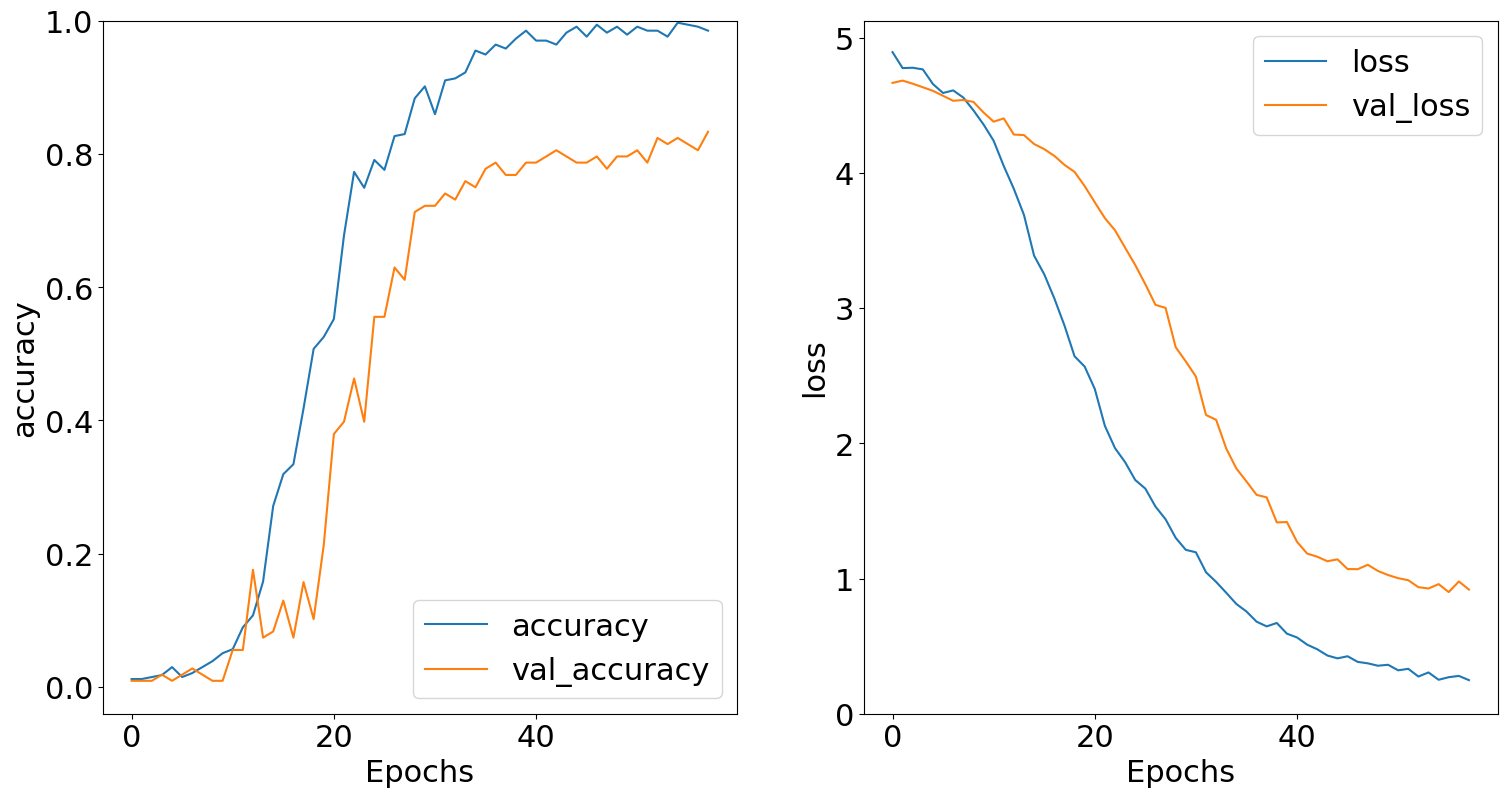

In [137]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(model,'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(model, 'loss')
plt.ylim(0, None)
plt.savefig('result', dpi=200, transparent=True, format='svg')

In [138]:
inp = 'hi'
result = model.predict(tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len), verbose=0)
print(NUM_CLASSES)
print(len(result[0]))
print(np.max(result))

if np.max(result) > 0.01:
  tag = le.inverse_transform([np.argmax(result)])
  print(tag)
else:
  print('not found')


96
96
0.98476
['greeting']


In [139]:
print(result[0])


[7.42829070e-05 2.07489677e-04 4.55083318e-05 2.32477050e-05
 5.98746519e-05 3.76839344e-05 5.34266178e-07 3.39764961e-06
 3.98912562e-06 3.22628221e-05 1.42203703e-06 1.23505197e-05
 3.06320580e-05 2.21663449e-05 2.76938634e-04 5.90141863e-04
 1.74137694e-03 7.44252520e-06 7.93234431e-05 2.02634768e-03
 5.61735869e-05 2.53653143e-05 9.57951925e-05 4.50107080e-07
 1.91639992e-04 5.24546020e-04 5.87835500e-04 2.66423394e-05
 7.43819051e-04 1.08355205e-04 4.16800642e-04 4.39656287e-06
 8.27876065e-05 2.02173906e-04 2.68663098e-05 7.64975903e-06
 2.28764584e-05 5.72726094e-05 2.35612770e-05 5.60396848e-06
 8.00707203e-05 2.13632302e-06 1.55531870e-06 3.61716729e-07
 1.51445884e-05 1.11782983e-05 1.51839020e-04 2.15359600e-04
 2.41982834e-05 1.40710326e-04 8.82363587e-04 9.84059079e-06
 2.22277758e-05 1.91126110e-05 2.62989470e-05 1.38428786e-05
 7.04796378e-07 2.39987639e-06 5.54320926e-04 2.24067582e-04
 9.27167378e-07 1.24769913e-05 1.86782727e-05 3.09711439e-04
 2.48718483e-04 9.847599

In [140]:
# to save the trained model
model.save("/content/drive/MyDrive/magh6/english/model1")

import pickle

# to save the fitted tokenizer
with open('/content/drive/MyDrive/magh6/english/tokenizer1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# to save the fitted label encoder
with open('/content/drive/MyDrive/magh6/english/label_encoder1.pickle', 'wb') as ecn_file:
    pickle.dump(le, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

In [141]:
storage = pd.DataFrame(columns=['Date'])


In [142]:
storage.to_csv('/content/drive/MyDrive/magh6/english/storage.csv', index=False)


In [143]:
pip install fuzzywuzzy


In [144]:
# prompt: installpython-Levenshtein

!pip install python-Levenshtein


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.8 MB/s eta 0:00:00


In [145]:
import json
from fuzzywuzzy import fuzz
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

import spacy
import random
import pickle

with open(data_path) as file:
    data = json.load(file)

storage = pd.read_csv('/content/drive/MyDrive/magh6/english/storage.csv')

import spacy

NER = spacy.load("en_core_web_sm")

def chat():
    # load trained model
    model = keras.models.load_model('/content/drive/MyDrive/magh6/english/model1')

    # load tokenizer object
    with open('/content/drive/MyDrive/magh6/english/tokenizer1.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('/content/drive/MyDrive/magh6/english/label_encoder1.pickle', 'rb') as enc:
        le = pickle.load(enc)

       # load Spacy NER
    nlp = spacy.load("en_core_web_sm")

    # parameters
    max_len = 20

    while True:
        print("User: ")
        inp = input()
        text = nlp(inp)
        for word in text.ents:
            if word.label_ == 'DATE':
                storage['Date'] = word.text

        if inp.lower() == "quit":
            break

        # Fuzzy String Matching
        max_similarity = 0
        best_match_tag = None

        for i in data['intents']:
            for pattern in i['patterns']:
                similarity = fuzz.ratio(inp.lower(), pattern.lower())
                if similarity > max_similarity:
                    max_similarity = similarity
                    best_match_tag = i['tag']

        if max_similarity >= 80:  # Adjust the similarity threshold as needed
            tag = best_match_tag
        else:
            result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                                 truncating='post', maxlen=max_len), verbose=0)
            tag = le.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['tag'] == tag:
                selected_response = np.random.choice(i['responses'])

                print("Selected Response:", selected_response)  # Debugging print statement

                if 'text' in selected_response:
                    print("ChatBot: " + selected_response['text'])

                if 'table' in selected_response:
                    headers = selected_response['table']['headers']
                    rows = selected_response['table']['rows']

                    # Display the table
                    print("ChatBot:")
                    print(f"{headers[0]:<30} {headers[1]}")
                    for row in rows:
                        if len(row) >= 2:
                            print(f"{row[0]:<30} {row[1]}")
                        else:
                            print("Invalid table row format.")

                if 'url' in selected_response:
                  print("ChatBot: Image related to the response:")
                  print(selected_response['url'])



In [147]:
print("Start messaging with the bot (type quit to stop)!")
chat()

Start messaging with the bot (type quit to stop)!
User: 
hi
Selected Response: Hi,I am KEC Chatbot.If you have any questions,feel free to ask.
User: 
where is kec located?
Selected Response: Our college is located at kalimati,kathmandu.For detailed direction <a target="_blank" href="https://maps.app.goo.gl/CPpCvJfDe2wkCBr3A">visit here</a>
User: 
who are the members of computer faculty
Selected Response: {'text': 'Computer Faculty Members:', 'table': {'headers': ['Name', 'Position'], 'rows': [['Er. Sudeep Shakya', 'HOD / Associate Professor'], ['Er. Kunjan Amatya', 'Dy. HOD / Associate professor/ Research Member'], ['Er. Mahesh Singh Kathayat', 'Academic Advisor / Associate Professor'], ['Er. Shyam Dahal', 'Hostel Warden / Associate Professor'], ['Er. Shree Krishna Sulu', 'Dy. Exam Head / Associate Professor'], ['Er. Nabin Neupane', '3rd Year Coordinator / Associate Professor'], ['Er. Sharad Chandra Joshi', 'Associate Professor / Major Project Coordinator'], ['Er. Anju Khanal', 'Sr. Le

In [148]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [149]:
# Predictions on validation data
val_predictions = model.predict(V_padded_sequences)
val_predictions = np.argmax(val_predictions, axis=1)

4/4 [==============================] - 0s 6ms/step


In [150]:
# Calculate accuracy
accuracy = accuracy_score(val_y, val_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8148148148148148


In [151]:
# Calculate precision
precision = precision_score(val_y, val_predictions, average='weighted')
print("Precision:", precision)


Precision: 0.7723765432098766


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [152]:
# Calculate recall
recall = recall_score(val_y, val_predictions, average='weighted')
print("Recall:", recall)

Recall: 0.8148148148148148


In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

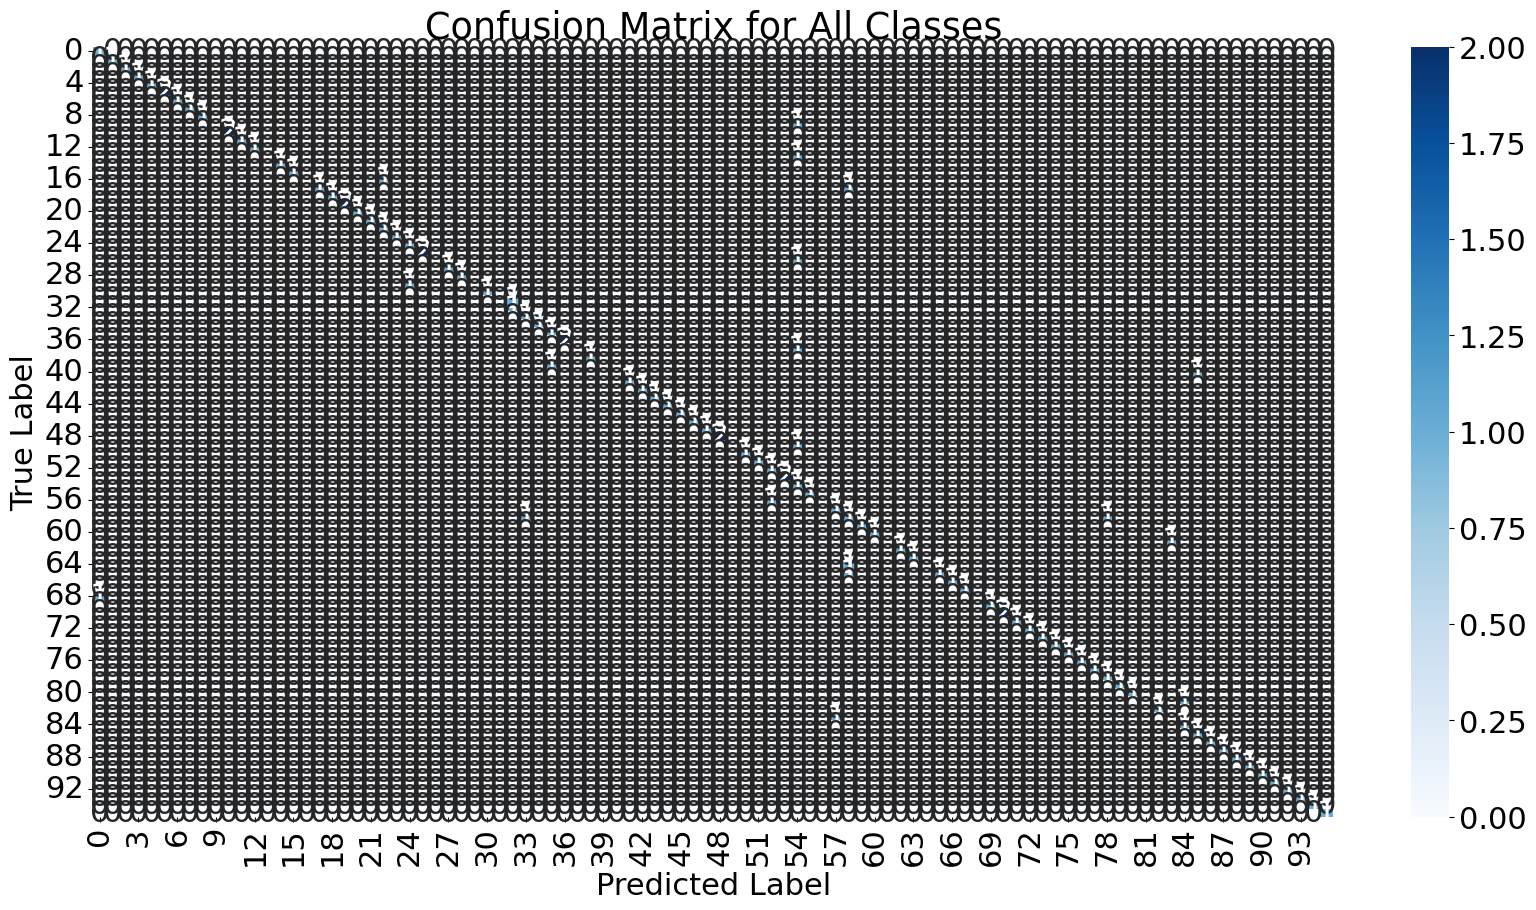

In [158]:
# Compute the confusion matrix for all classes
conf_matrix = confusion_matrix(val_y, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for All Classes')
plt.show()
